In [576]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable

import math

import time

from matplotlib import cm

import matplotlib.lines as mlines

%matplotlib inline

### AIR POLLUTION MONITORING DATA FROM EDF

In [577]:
df = pd.read_csv('EDF_Data.csv', header = 1)
df['TimePeriod'] = 'Jun2015-May2016'
df.tail()

Longitude   Latitude    NO Value  NO2 Value  BC Value       TimePeriod
21483 -122.034943  37.560076  129.999995  44.778220  3.923761  Jun2015-May2016
21484 -122.034724  37.560164   60.799998  39.027545  1.408693  Jun2015-May2016
21485 -122.034681  37.559830   34.622951  28.816797  2.659885  Jun2015-May2016
21486 -122.034504  37.559958   74.764705  35.735434  1.776353  Jun2015-May2016
21487 -122.034503  37.559957   78.754782  41.062757  2.014664  Jun2015-May2016

In [578]:
df.shape

(21488, 6)

In [579]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]

### Split the dataset into BC and NO2 since we are interested only in those two pollutants

In [580]:
BC_df = df[['Longitude', 'Latitude', 'BC Value', 'TimePeriod']]

In [581]:
NO2_df = df[['Longitude', 'Latitude', 'NO2 Value', 'TimePeriod']]

In [582]:
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

### FACILITY LEVEL DATA

In [583]:
# Read data for Oakland and drop duplicate facility ids
oak_facility = pd.read_csv('Data/oakland_facility_2017.csv', header = 0)
# Display all columns in the dataframe
oak_facility.columns

Index(['Unnamed: 0', 'county', 'eis facility id', 'agency facility id',
       'tri facility id', 'company name', 'site name', 'facility source type',
       'site latitude', 'site longitude', 'address', 'city', 'zip code',
       'pollutant code', 'pollutant type(s)', 'total emissions',
       'emissions uom', 'data set'],
      dtype='object')

In [584]:
# Drop columns that are not needed 
oak_facility.drop(columns = ['agency facility id', 'tri facility id','pollutant type(s)', 'data set',
                             'site name', 'address','Unnamed: 0', 'county'], inplace=True)

In [585]:
# Rename site latitude and site longitude column to just latitude and logitude
oak_facility.rename(columns={"site latitude": "latitude", "site longitude": "longitude", 'facility source type':'source-category'}, inplace=True)

In [586]:
# Display all columns in the dataframe
oak_facility.columns

Index(['eis facility id', 'company name', 'source-category', 'latitude',
       'longitude', 'city', 'zip code', 'pollutant code', 'total emissions',
       'emissions uom'],
      dtype='object')

In [587]:
# Filter the dataframe further for sources/facilities only in Oakland and neighbouring cities like San Leandro, Piedmont, Alameda and Berkeley
oak_facility = oak_facility[(oak_facility['city'] == 'OAKLAND') | (oak_facility['city'] == 'SAN LEANDRO') | (oak_facility['city'] == 'BERKELEY')|
                           (oak_facility['city'] == 'ALAMEDA') | (oak_facility['city'] == 'PIEDMONT')]

In [588]:
oak_facility.head(50)

eis facility id                    company name  \
3             126911                    PACIFIC BELL   
4             126911                    PACIFIC BELL   
5             126911                    PACIFIC BELL   
9             127111                    PACIFIC BELL   
10            127111                    PACIFIC BELL   
11            127111                    PACIFIC BELL   
18            127511                    PACIFIC BELL   
19            127511                    PACIFIC BELL   
20            127511                    PACIFIC BELL   
21            127611                    PACIFIC BELL   
22            127611                    PACIFIC BELL   
23            127611                    PACIFIC BELL   
24            127711                    PACIFIC BELL   
25            127711                    PACIFIC BELL   
26            127711                    PACIFIC BELL   
27            127811                    PACIFIC BELL   
28            127811                    PACIFIC BELL   
29            127811                    PACIFIC BELL   
33            128211                    PACIFIC BELL   
34            128211                    PACIFIC BELL   
35            128211                    PACIFIC BELL   
48            130511               KAISER PERMANENTE   
49            130511               KAISER PERMANENTE   
50            130511               KAISER PERMANENTE   
51            136511     NORTHERN CALIF POWER AGENCY   
52            136511     NORTHERN CALIF POWER AGENCY   
53            136511     NORTHERN CALIF POWER AGENCY   
54            137211  KAISER PERMANENTE MEDICAL CENT   
55            137211  KAISER PERMANENTE MEDICAL CENT   
56            137211  KAISER PERMANENTE MEDICAL CENT   
63            137811            UNCOMMON GROUNDS,INC   
64            137811            UNCOMMON GROUNDS,INC   
65            137811            UNCOMMON GROUNDS,INC   
77            138911    PRECISION TECHNICAL COATINGS   
78            138911    PRECISION TECHNICAL COATINGS   
81            139211   AGRICULTURAL RESEARCH SERVICE   
82            139211   AGRICULTURAL RESEARCH SERVICE   
83            139211   AGRICULTURAL RESEARCH SERVICE   
86            140211  SVC MANUFACTURING, INC DBA PEP   
87            140211  SVC MANUFACTURING, INC DBA PEP   
88            140211  SVC MANUFACTURING, INC DBA PEP   
101           141411   AC TRANSIT DISTRICT - CENTRAL   
102           141411   AC TRANSIT DISTRICT - CENTRAL   
103           141411   AC TRANSIT DISTRICT - CENTRAL   
107           168111  EAST BAY DISCHARGERS AUTHORITY   
108           168111  EAST BAY DISCHARGERS AUTHORITY   
109           168111  EAST BAY DISCHARGERS AUTHORITY   
113           168411                       CASS, INC   
114           168411                       CASS, INC   
115           168411                       CASS, INC   

                                    source-category  latitude  longitude  \
3                                               NaN  37.76685 -122.24972   
4                                               NaN  37.76685 -122.24972   
5                                               NaN  37.76685 -122.24972   
9                                               NaN  37.86771 -122.26784   
10                                              NaN  37.86771 -122.26784   
11                                              NaN  37.86771 -122.26784   
18                                              NaN  37.80603 -122.26946   
19                                              NaN  37.80603 -122.26946   
20                                              NaN  37.80603 -122.26946   
21                                              NaN  37.78422 -122.22241   
22                                              NaN  37.78422 -122.22241   
23                                              NaN  37.78422 -122.22241   
24                                              NaN  37.83336 -122.26307   
25                                              NaN  37.83336 -122.26307   
26      

In [589]:
### First clean up source-category column
oak_facility['source-category'] = oak_facility['source-category'].replace({'Institutional (school, hospital, prison, etc.)':'Institution', 'Breweries/Distilleries/Wineries':'Breweries-Distilleries-Wineries'})
oak_facility.replace(' ', '-',regex=True,inplace=True)
oak_facility.replace(',', '-',regex=True,inplace=True)
oak_facility.replace('---', '-',regex=True,inplace=True)
oak_facility.replace('--', '-',regex=True,inplace=True)
oak_facility.replace(np.nan, 'Unknown', regex= True, inplace=True)

In [590]:
oak_facility['source-category'].unique()


array(['Unknown', 'Institution', 'Electricity-Generation-via-Combustion',
       'Concrete-Batch-Plant', 'Hot-Mix-Asphalt-Plant',
       'Wastewater-Treatment-Facility', 'Crematory-Human',
       'Food-Products-Processing-Plant',
       'Breweries-Distilleries-Wineries',
       'Auto-Body-Painting-or-Repair-Shop', 'Foundries-Iron-and-Steel',
       'Fiberglass-Products-Manuf', 'Bakeries',
       'Dry-Cleaner-Petroleum-Solvent', 'Pharmaceutical-Manufacturing',
       'Landfill', 'Airport', 'Concrete-Block-Pipe-or-Other-Manuf'],
      dtype=object)

#### Before dropping columns, create a dataframe which has a mapping of EIS facility id and the source type; write into a separate dataframe
EIS_source_type = oak_facility[['eis facility id', 'company name','source-category','city']]
EIS_source_type.to_csv("Data/eis-source-type-mapping.csv")

In [594]:
## Creating a separate dataframe for NOx
Facility_NO2 = oak_facility[oak_facility['pollutant code'] == 'NOX']

In [595]:
Facility_NO2.shape

(328, 10)

In [596]:
## Creating a separate dataframe for PM/Black carbon
Oak_PM10_25 = oak_facility[oak_facility['pollutant code'] != 'NOX']

In [597]:
PM10_pri = Oak_PM10_25[Oak_PM10_25['pollutant code']=='PM10-PRI']

In [598]:
## Drop PM10-PRI rows in Oak_PM dataframe
Oak_PM25  = Oak_PM10_25[Oak_PM10_25['pollutant code'] == 'PM25-PRI']

In [599]:
Facility_PM = pd.merge(Oak_PM25, PM10_pri, left_on ='eis facility id', right_on ='eis facility id', how='inner')


In [600]:
Facility_PM

eis facility id company name_x source-category_x  latitude_x  \
0             126911   PACIFIC-BELL           Unknown   37.766850   
1             127111   PACIFIC-BELL           Unknown   37.867710   
2             127511   PACIFIC-BELL           Unknown   37.806030   
3             127611   PACIFIC-BELL           Unknown   37.784220   
4             127711   PACIFIC-BELL           Unknown   37.833360   
..               ...            ...               ...         ...   
357         18778911        Unknown           Unknown   37.712960   
358         18779811        Unknown           Unknown   37.707820   
359         18781211        Unknown           Unknown   37.812106   
360         18782611        Unknown           Unknown   37.759959   
361         18787011        Unknown           Unknown   37.766939   

     longitude_x       city_x  zip code_x pollutant code_x  total emissions_x  \
0    -122.249720      ALAMEDA       94501         PM25-PRI           0.000731   
1    -122.267840     BERKELEY       94704         PM25-PRI           0.002173   
2    -122.269460      OAKLAND       94612         PM25-PRI           0.008291   
3    -122.222410      OAKLAND       94601         PM25-PRI           0.000706   
4    -122.263070      OAKLAND       94609         PM25-PRI           0.001554   
..           ...          ...         ...              ...                ...   
357  -122.188680  SAN-LEANDRO       94577         PM25-PRI          22.124544   
358  -122.185500  SAN-LEANDRO       94577         PM25-PRI           0.000015   
359  -122.186447      OAKLAND       94621         PM25-PRI           0.000061   
360  -122.207782      OAKLAND       94621         PM25-PRI           0.992654   
361  -122.216336      OAKLAND       94621         PM25-PRI           0.079014   

    emissions uom_x company name_y source-category_y  latitude_y  longitude_y  \
0               TON   PACIFIC-BELL           Unknown   37.766850  -122.249720   
1               TON   PACIFIC-BELL           Unknown   37.867710  -122.267840   
2               TON   PACIFIC-BELL           Unknown   37.806030  -122.269460   
3               TON   PACIFIC-BELL           Unknown   37.784220  -122.222410   
4               TON   PACIFIC-BELL           Unknown   37.833360  -122.263070   
..              ...            ...               ...         ...          ...   
357             TON        Unknown           Unknown   37.712960  -122.188680   
358             TON        Unknown           Unknown   37.707820  -122.185500   
359             TON        Unknown           Unknown   37.812106  -122.186447   
360             TON        Unknown           Unknown   37.759959  -122.207782   
361             TON        Unknown           Unknown   37.766939  -122.216336   

          city_y  zip code_y pollutant code_y  total emissions_y  \
0        ALAMEDA       94501         PM10-PRI           0.000749   
1       BERKELEY       94704         PM10-PRI           0.002226   
2        OAKLAND       94612         PM10-PRI           0.008494   
3        OAKLAND       94601         PM10-PRI           0.000724   
4        OAKLAND       94609         PM10-PRI           0.001592   
..           ...         ...              ...                ...   
357  SAN-LEANDRO       94577         PM10-PRI          22.971518   
358  SAN-LEANDRO       94577         PM10-PRI           0.000015   
359      OAKLAND       94621         PM10-PRI           0.000061   
360      OAKLAND       94621         PM10-PRI           1.030213   
361      OAKLAND       94621         PM10-PRI           0.131690   

    emissions uom_y  
0               TON  
1               TON  
2               TON  
3               TON  
4               TON  
..              ...  
357             TON  
358             TON  
359             TON  
360             TON  
361             TON  

[362 rows x 19 columns]

In [601]:
Facility_PM.drop(columns = ['zip code_x','pollutant code_x', 'emissions uom_x','company name_y','latitude_y','longitude_y',
                      'city_y','zip code_y','pollutant code_y','emissions uom_x', 'source-category_y'], inplace=True)

In [602]:
# Rename columns to meaningful names
Facility_PM.rename(columns={"latitude_x": "latitude", "longitude_x": "longitude", "city_x": "city", 
                       "total emissions_x" : "PM25", "total emissions_y": "PM10", "emissions uom_y": "units", 
                           "source-category_x":"source-category", "company name_x":"company"}, inplace=True)

In [603]:
Facility_PM.head()

eis facility id       company source-category  latitude  longitude  \
0           126911  PACIFIC-BELL         Unknown  37.76685 -122.24972   
1           127111  PACIFIC-BELL         Unknown  37.86771 -122.26784   
2           127511  PACIFIC-BELL         Unknown  37.80603 -122.26946   
3           127611  PACIFIC-BELL         Unknown  37.78422 -122.22241   
4           127711  PACIFIC-BELL         Unknown  37.83336 -122.26307   

       city      PM25      PM10 units  
0   ALAMEDA  0.000731  0.000749   TON  
1  BERKELEY  0.002173  0.002226   TON  
2   OAKLAND  0.008291  0.008494   TON  
3   OAKLAND  0.000706  0.000724   TON  
4   OAKLAND  0.001554  0.001592   TON

In [604]:
Facility_PM.shape

(362, 9)

In [605]:
Facility_NO2['city'].unique()

array(['ALAMEDA', 'BERKELEY', 'OAKLAND', 'SAN-LEANDRO', 'PIEDMONT'],
      dtype=object)

## TRAFFIC DATA

In [696]:
### Load Annual Average Daily Traffic (AADT) file from Caltrans
traffic = pd.read_csv('Data/Traffic_Oakland_AADT.csv', header = 0)

In [697]:
# Drop columns that are unneccessary and choose only Ahead_AADT, along with N/E latitude and longitude
traffic.drop(columns = ['OBJECTID','District','Route','County', 'Postmile', 
                        'Back_pk_h', 'Back_pk_m', 'Ahead_pk_h', 'Ahead_pk_m','Back_AADT','Lat_S_or_W', 'Lon_S_or_W'], inplace=True)

In [698]:
traffic.rename(columns={"Ahead_AADT":"AADT", "Lat_N_or_E":"Latitude", "Lon_N_or_E":"Longitude", "Descriptn":"Description"}, inplace=True)

In [699]:
traffic.head()

Description   AADT   Latitude   Longitude
0        ALAMEDA, BROADWAY/ ENCINAL AVENUE   8700  37.760576 -122.240708
1  ALAMEDA, CENTRAL AVENUE/ SHERMAN STREET   9500  37.770910 -122.263477
2                      JCT. RTE. 260 NORTH      0  37.771459 -122.276894
3                   OAKLAND, JCT. RTE. 880  22900  37.769397 -122.221166
4                OAKLAND, EAST 12TH STREET  16400  37.772068 -122.217378

In [700]:
# Taking a closer look at the traffic data, there are some intersections where the AADT is zero, or the latitude and longitude are zero. We want to drop these rows
traffic = traffic[(traffic['Longitude']<-1) & (traffic['AADT']>1)]

In [701]:
traffic.shape

(71, 4)

## Converting facility and traffic dataframe into a geopandas dataframe for plotting

In [612]:
# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility = [Point(xy) for xy in zip(oak_facility['longitude'], oak_facility['latitude'])]

In [613]:
# Create a geopandas dataframe with the coordinate reference system as epsg4326
geo_df_facility = gpd.GeoDataFrame(oak_facility, crs = crs, geometry = geometry_facility)

In [614]:
# Create a geopandas dataframe with traffic data
geometry_traffic = [Point(xy) for xy in zip(traffic['Longitude'], traffic['Latitude'])]
geo_df_traffic = gpd.GeoDataFrame(traffic, crs = crs, geometry = geometry_traffic)

In [615]:
# Create a list of x and y coordinates for the PM facility data in Oakland using geopandas
geometry_facility_PM = [Point(xy) for xy in zip(Facility_PM['longitude'], Facility_PM['latitude'])]
geo_df_facility_PM = gpd.GeoDataFrame(Facility_PM, crs = crs, geometry = geometry_facility_PM)

In [616]:
# Create a list of x and y coordinates for the Black Carbon concentration data using geopandas
geometry_df_BC = [Point(xy) for xy in zip(BC_df['Longitude'], BC_df['Latitude'])]
geo_df_BC = gpd.GeoDataFrame(BC_df, crs = crs, geometry = geometry_df_BC)

## Pu(lo)tting all together  

### Plotting Oakland Basemap (shapefile)

In [617]:
oakl = gpd.read_file('Oakland-shapefile/OaklandZoning_Eff20181211_Ord13513.shp')

In [618]:
oakl.head()

FID  OBJECTID           AREA    PERIMETER  BASEZONE OVERLAY   ZNLABEL  \
0    1      2564  463428.469786  3325.153525      RM-3    None      RM-3   
1    2      1813  558079.266415  6474.259271  OS (RCA)    None  OS (RCA)   
2    3      2139   43129.700341  1086.970123      CC-2    /S-7  CC-2/S-7   
3    4      2565  104035.317933  1328.336204      RM-3    None      RM-3   
4    5      1814  553731.995607  3549.473783      CC-1    None      CC-1   

  ORDINANCE LASTUPDATE                                GLOBALID     SHAPE_AREA  \
0      None   20180327  {9D6F625B-B567-4B94-86EF-A5BCB06DC547}  463428.469786   
1     13276   20180327  {A2EC4B15-CBDD-499C-8660-B70F90566564}  558079.266419   
2      None   20180327  {BF636AD7-DD80-47FA-B2D0-97614B55EC75}   43129.700340   
3      None   20180327  {A6197605-035A-4F64-AD67-084FB60661D7}  104035.317934   
4      None   20180327  {30FA7150-F5A0-489F-8415-2018DBB78376}  553731.995610   

     SHAPE_LEN    Shape__Are   Shape__Len  \
0  3325.153525  69024.062500  1283.361119   
1  6474.259271  83181.558594  2501.498512   
2  1086.970123   6430.570312   419.525144   
3  1328.336204  15495.957031   512.707291   
4  3549.473783  82541.093750  1370.391443   

                                            geometry  
0  POLYGON ((-122.19994 37.76732, -122.20039 37.7...  
1  POLYGON ((-122.25921 37.79733, -122.25922 37.7...  
2  POLYGON ((-122.29849 37.80666, -122.29850 37.8...  
3  POLYGON ((-122.19655 37.76915, -122.19627 37.7...  
4  POLYGON ((-122.18167 37.79756, -122.18167 37.7...

In [619]:
oakl.crs

{'init': 'epsg:4326'}

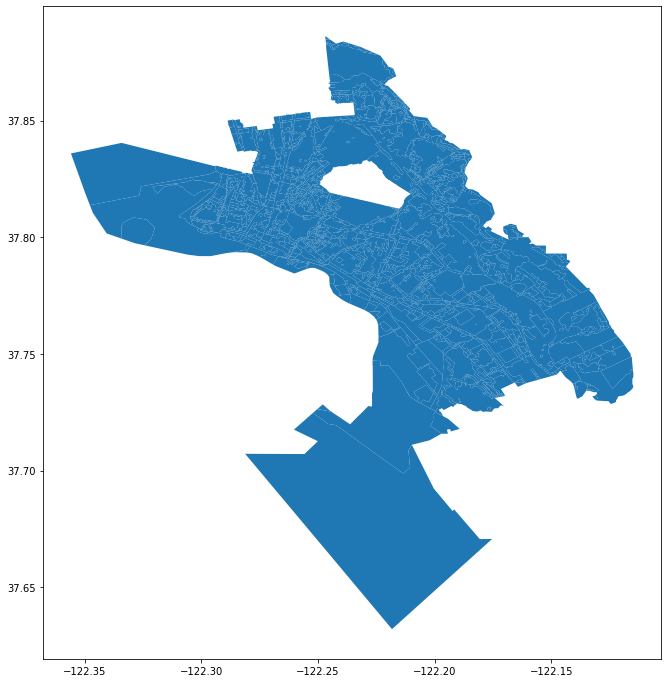

In [620]:
fig, ax = plt.subplots(figsize = (12,12))
oakl.plot(ax = ax)

### Plotting black carbon data and location of all near-by sources

##### Handles for City Name and Traffic Intersections


In [621]:
maroon_x = mlines.Line2D([], [], color='maroon', marker='x', linestyle='None',
                          markersize=6, label='Alameda')
orange_x = mlines.Line2D([], [], color='darkorange', marker='x', linestyle='None',
                          markersize=6, label='Berkeley')
yellow_x = mlines.Line2D([], [], color='lemonchiffon', marker='x', linestyle='None',
                          markersize=6, label='Oakland')
green_x = mlines.Line2D([], [], color='limegreen', marker='x', linestyle='None',
                          markersize=6, label='Piedmont')
blue_x = mlines.Line2D([], [], color='slateblue', marker='x', linestyle='None',
                          markersize=6, label='San Leandro')

fuchsia_o = mlines.Line2D([], [], color='fuchsia', marker='o', linestyle='None',
                          markersize=6, label='Traffic ')


##### Handles for facility types

maroon_D = mlines.Line2D([], [], color='maroon', marker='D', linestyle='None',
                          markersize=6, label='Airport')
orange_D = mlines.Line2D([], [], color='darkorange', marker='D', linestyle='None',
                          markersize=6, label='Auto-Body-Painting-or-Repair-Shop')
yellow_D = mlines.Line2D([], [], color='lemonchiffon', marker='D', linestyle='None',
                          markersize=6, label='Bakeries')
darkviolet_D = mlines.Line2D([], [], color='darkviolet', marker='D', linestyle='None',
                          markersize=6, label='Breweries-Distilleries-Wineries')
green_D = mlines.Line2D([], [], color='limegreen', marker='D', linestyle='None',
                          markersize=6, label='Concrete-Batch-Plant')
blue_D = mlines.Line2D([], [], color='blue', marker='D', linestyle='None',
                          markersize=6, label='Concrete-Block-Pipe-or-Other-Manuf')
fuchsia_D = mlines.Line2D([], [], color='fuchsia', marker='D', linestyle='None',
                          markersize=6, label='Crematory-Human ')
black_D = mlines.Line2D([], [], color = 'black', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Dry-Cleaner-Petroleum-Solvent')
red_D = mlines.Line2D([], [], color = 'red', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Electricity-Generation-via-Combustion')
cyan_D = mlines.Line2D([], [], color = 'cyan', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Fiberglass-Products-Manuf')
peru_D = mlines.Line2D([], [], color = 'peru', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Food-Products-Processing-Plant')
palegreen_D = mlines.Line2D([], [], color = 'palegreen', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Foundries-Iron-and-Steel')
pink_D = mlines.Line2D([], [], color = 'pink', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Hot-Mix-Asphalt-Plant')
dimgrey_D = mlines.Line2D([], [], color = 'dimgrey', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Institution')
gold_D = mlines.Line2D([], [], color = 'gold', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Landfill')
dodgerblue_D = mlines.Line2D([], [], color = 'dodgerblue', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Pharmaceutical-Manufacturing')
forestgreen_D = mlines.Line2D([], [], color = 'forestgreen', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Unknown')
slateblue_D = mlines.Line2D([], [], color = 'slateblue', marker = 'D', linestyle = 'None',
                       markersize = 6, label = 'Wastewater-Treatment-Facility')

keys = set(keys)
keys = sorted(keys)
list(keys)
custom_colors = ['maroon', 'darkorange', 'lemonchiffon', 'darkviolet', 'limegreen', 'blue', 'fuchsia','black','red',
                 'cyan','peru','palegreen','pink','dimgrey','gold','dodgerblue','forestgreen','slateblue']

color_dict = dict(zip(keys, custom_colors))

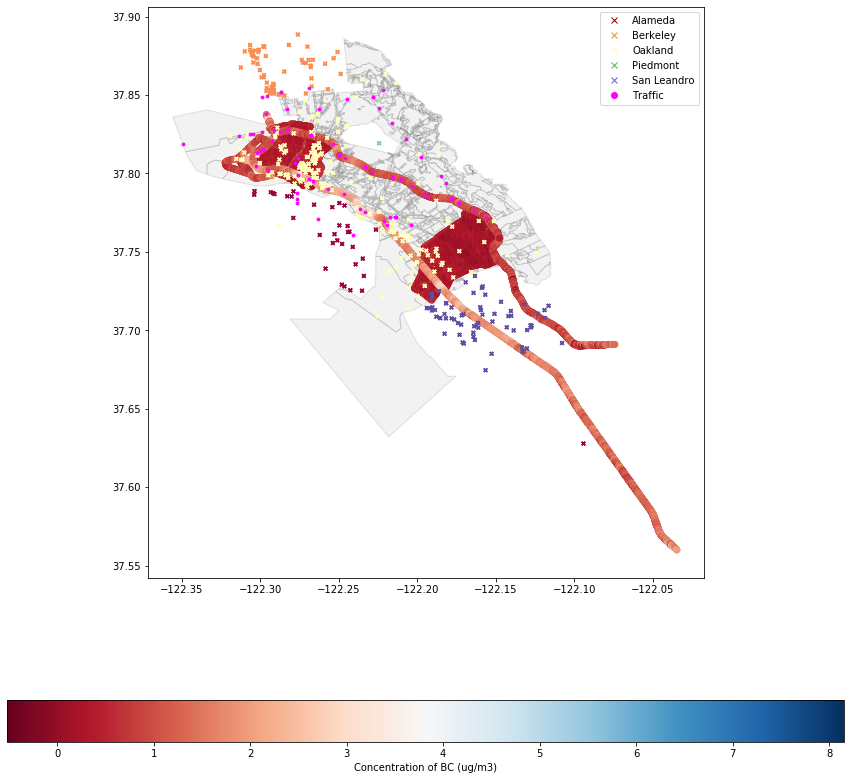

In [622]:
fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df['BC Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df['BC Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.xlim([-122.32,-122.25])
#plt.ylim([37.76,37.9])
#plt.ylim([37.8,37.82])


#cax = fig.add_axes([1, 0.05, 0.03, 0.8])
sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#sm._A = []
#cbr = fig.colorbar(sm)
#cbr.ax.tick_params(labelsize=20) 
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of BC (ug/m3)')
geo_df_facility.plot(ax=ax, cmap='Spectral', column = 'city', legend = True, marker='x', markersize = 12)
geo_df_traffic.plot(ax=ax, legend=True, marker='o', markersize = 8, color='fuchsia')
plt.legend(handles=[maroon_x, orange_x, yellow_x, green_x, blue_x, fuchsia_o])
#geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
#                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.tight_layout()
#plt.savefig(os.path.join('out','fig.png'),format = 'png',bbox_inches='tight')
plt.show()

#### Plotting NOx data and location of all near-by sources

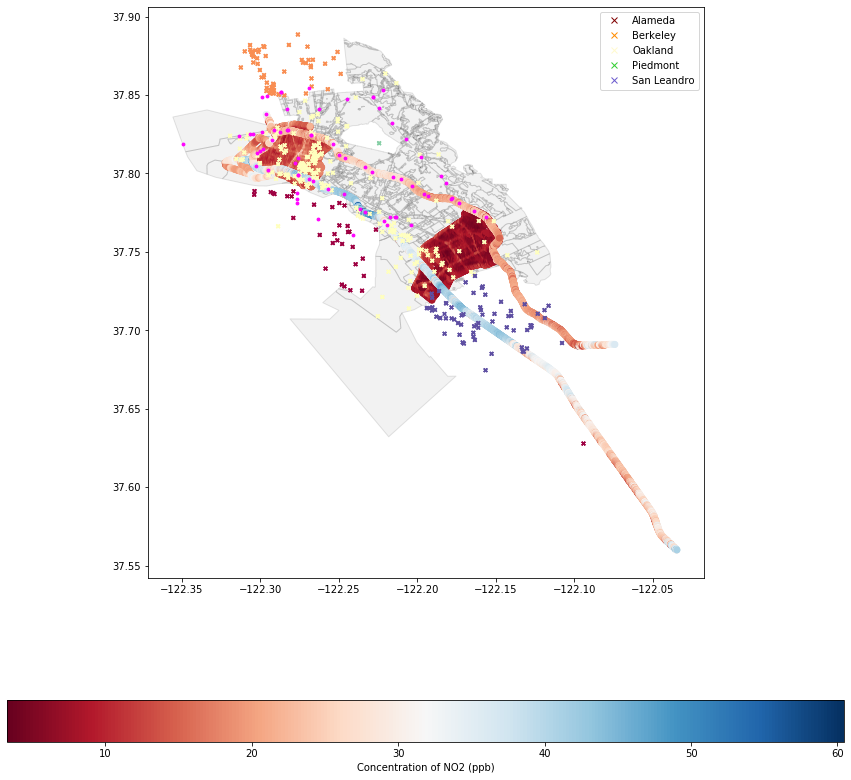

In [623]:
fig, ax = plt.subplots(figsize = (15,15)) #This creates a figure axis
vmin = geo_df['NO2 Value'].min()           #Minimum value of black carbon concentration for legend
vmax = geo_df['NO2 Value'].max()           #Maximum value of black carbon concentration for legend
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile


geo_df.plot(ax = ax, column = 'NO2 Value', legend=False, legend_kwds={'label': "Concentration of NO",
                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.xlim([-122.25,-122.15])
#plt.ylim([37.7,37.9])


#cax = fig.add_axes([1, 0.05, 0.03, 0.8])
sm = cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
#sm._A = []
#cbr = fig.colorbar(sm)
#cbr.ax.tick_params(labelsize=20) 
ax.get_figure().colorbar(sm, ax=ax, orientation='horizontal', label = 'Concentration of NO2 (ppb)')
geo_df_facility.plot(ax=ax, cmap='Spectral', column = 'city', legend = True, marker='x', markersize = 12)
geo_df_traffic.plot(ax=ax, legend=True, marker='o', markersize = 8, color='fuchsia')
plt.legend(handles=[maroon_x, orange_x, yellow_x, green_x, blue_x])
#geo_df.plot(ax = ax, column = 'BC Value', legend=False, legend_kwds={'label': "Concentration of NO",
#                                                                    'orientation': "horizontal"}, cmap = 'RdBu')
#plt.tight_layout()
#plt.savefig(os.path.join('out','fig.png'),format = 'png',bbox_inches='tight')
plt.show()

## Creating input dataframe - Method 1: 
### Here I find the nearest facility or traffic intersection to each point in the EDF data. The corresponding BC/NOx values or AADT values will be included as an addiitonal column. 

### Find Closest Facility and Traffic Intersection to each point in the EDF data

#### Unary Union of the geo_df geometry - Closest Facility

pts = geo_df_facility_PM.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_facility_PM.geometry == nearest_points(point, pts)[1]
     return geo_df_facility_PM[nearest]['eis facility id'].to_numpy()[0]
geo_df_BC['Nearest_Facility'] = geo_df_BC.apply(lambda row: near(row.geometry), axis=1)

#### Unary Union of the geo_df geometry - Closest Traffic Intersection

pts = geo_df_traffic.geometry.unary_union
def near(point, pts=pts):
     # find the nearest point and return the corresponding Station name
     nearest = geo_df_traffic.geometry == nearest_points(point, pts)[1]
     return geo_df_traffic[nearest]['Description'].to_numpy()[0]
geo_df_BC['Nearest_Traffic'] = geo_df_BC.apply(lambda row: near(row.geometry), axis=1)

#### Merge df_BC with Oak_PM on Facility ID
df_BC_merge = pd.merge(left=df_BC, right=Oak_PM, left_on='Nearest_Facility', right_on='eis facility id')

#### Merge above dataframe with traffic
df_BC_merge_traffic = pd.merge(left=df_BC_merge, right=traffic, left_on='Nearest_Traffic', right_on='Description')

df_BC_merge_traffic.head()

df_BC_merge_traffic.rename(columns={'Latitude_x':'Latitude_Conc','Longitude_x':'Longitude_Conc','latitude':'Latitude_Fac','longitude':'Longitude_Fac','Latitude_y':'Latitude_Traf','Longitude_y':'Longitude_Traf'}, inplace=True)

df_BC_merge_traffic.head()

df_BC_merge_traffic.columns

#### Create an empty list call dist which stores all the distances between each point (facility and traffic)
dist_fac = []
dist_traf = []

### Defining a function to calculate the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

for row in df_BC_merge_traffic.iterrows():
    dist_fac.append(distance((row[1]['Latitude_Conc'], row[1]['Longitude_Conc']), (row[1]['Latitude_Fac'], row[1]['Longitude_Fac'])))
    dist_traf.append(distance((row[1]['Latitude_Conc'], row[1]['Longitude_Conc']), (row[1]['Latitude_Traf'], row[1]['Longitude_Traf'])))

df_BC_merge_traffic['Dist_Facility_mi'] = np.array(dist_fac)*0.621
df_BC_merge_traffic['Dist_Traffic_mi'] = np.array(dist_traf)*0.621

#### Drop columns from df_BC_merge that are not needed anymore
df_BC_merge_traffic.drop(columns = ['eis facility id','company name_x','city','units', 'Description', 'Nearest_Traffic'], inplace=True)

#### Rename columns
df_BC_merge_traffic.rename(columns = {'geometry_x':'Conc_geo', 'geometry_y':'Fac_geo','geometry':'Traf_geo'}, inplace=True)

df_BC_merge_traffic.head()

## Creating input dataframe - Method 2: 
#### In this approach, distance to each individual industry from the point of measurement, and the corresponding PM10 and PM2.5 emissions are indivudial features. Looking at the map further, industrial sources in Oakland, Piedmont and Alameda are closest to the measurement points. We filter out all other industrial sources. 

### Combining Air Pollution Monitoring Data and Facility level data

In [624]:
Facility_PM_All = Facility_PM.copy()

In [625]:
Facility_PM = Facility_PM[(Facility_PM['city'] == 'OAKLAND') | (Facility_PM['city'] == 'SAN LEANDRO') | (Facility_PM['city'] == 'ALAMEDA')]

In [626]:
Facility_PM.shape

(235, 10)

In [627]:
Facility_PM.describe()

eis facility id    latitude   longitude          PM25          PM10
count     2.350000e+02  235.000000  235.000000  2.350000e+02  2.350000e+02
mean      1.205261e+07   37.786949 -122.248781  4.365372e-01  6.287574e-01
std       6.191589e+06    0.032844    0.038997  2.157820e+00  3.110710e+00
min       1.269110e+05   37.627747 -122.319375  4.000000e-09  5.000000e-09
25%       1.047096e+07   37.762665 -122.274348  1.271505e-04  1.286320e-04
50%       1.411511e+07   37.796854 -122.262350  6.705310e-04  6.882760e-04
75%       1.724556e+07   37.809185 -122.219425  1.386779e-02  2.016354e-02
max       1.878701e+07   37.863670 -122.094062  1.835081e+01  2.626146e+01

In [628]:
Facility_PM.head()

eis facility id       company source-category  latitude  longitude  \
0           126911  PACIFIC-BELL         Unknown  37.76685 -122.24972   
2           127511  PACIFIC-BELL         Unknown  37.80603 -122.26946   
3           127611  PACIFIC-BELL         Unknown  37.78422 -122.22241   
4           127711  PACIFIC-BELL         Unknown  37.83336 -122.26307   
5           127811  PACIFIC-BELL         Unknown  37.81186 -122.19840   

      city      PM25      PM10 units                     geometry  
0  ALAMEDA  0.000731  0.000749   TON  POINT (-122.24972 37.76685)  
2  OAKLAND  0.008291  0.008494   TON  POINT (-122.26946 37.80603)  
3  OAKLAND  0.000706  0.000724   TON  POINT (-122.22241 37.78422)  
4  OAKLAND  0.001554  0.001592   TON  POINT (-122.26307 37.83336)  
5  OAKLAND  0.000336  0.000344   TON  POINT (-122.19840 37.81186)

#### Looking at the basic statistics of the emissions, we can filter out the rows below the 2nd quartile as the emissions are very low.  Typically, sources with more than 1 ton of annual emissions are considered as major sources, sources below this are typically considered a minor source. 

In [629]:
lower, upper = Facility_PM.PM10.quantile([0.5,1])
Facility_PM = Facility_PM.query('{low}<PM10<{high}'.format(low=lower,high=upper))

In [630]:
Facility_PM.head()

eis facility id                      company  \
0           126911                 PACIFIC-BELL   
2           127511                 PACIFIC-BELL   
3           127611                 PACIFIC-BELL   
4           127711                 PACIFIC-BELL   
8           136511  NORTHERN-CALIF-POWER-AGENCY   

                         source-category  latitude  longitude     city  \
0                                Unknown  37.76685 -122.24972  ALAMEDA   
2                                Unknown  37.80603 -122.26946  OAKLAND   
3                                Unknown  37.78422 -122.22241  OAKLAND   
4                                Unknown  37.83336 -122.26307  OAKLAND   
8  Electricity-Generation-via-Combustion  37.78683 -122.29108  ALAMEDA   

       PM25      PM10 units                     geometry  
0  0.000731  0.000749   TON  POINT (-122.24972 37.76685)  
2  0.008291  0.008494   TON  POINT (-122.26946 37.80603)  
3  0.000706  0.000724   TON  POINT (-122.22241 37.78422)  
4  0.001554  0.001592   TON  POINT (-122.26307 37.83336)  
8  0.407764  0.408587   TON  POINT (-122.29108 37.78683)

In [631]:
### Add an empty column for distance
Facility_PM['dist'] = 0
Facility_PM['dist'].astype(float)

0      0.0
2      0.0
3      0.0
4      0.0
8      0.0
      ... 
350    0.0
352    0.0
354    0.0
360    0.0
361    0.0
Name: dist, Length: 116, dtype: float64

#### Write into a csv file
Facility_PM.to_csv("Data/Facility_PM.csv")

#### We need to fill in the unknown categories for source-categories. I manually updated the source-type for most of the unknowns either based on the company name, or based on the location. The 'Facility_PM_updated' file is stored in the Data folder and is loaded here as Facility_PM. There are still 5-6 unknown sources in the dataframe. 


In [634]:
Facility_PM = pd.read_csv("Data/Facility_PM_updated.csv")

In [635]:
# Create a list of x and y coordinates to convert to a geodataframe using geopandas
geometry_facility = [Point(xy) for xy in zip(Facility_PM['longitude'], Facility_PM['latitude'])]

In [636]:
# Create a geopandas dataframe with the coordinate reference system as epsg4326
geo_df_facility = gpd.GeoDataFrame(Facility_PM, crs = crs, geometry = geometry_facility)

#### Plotting only industrial facilities in the area

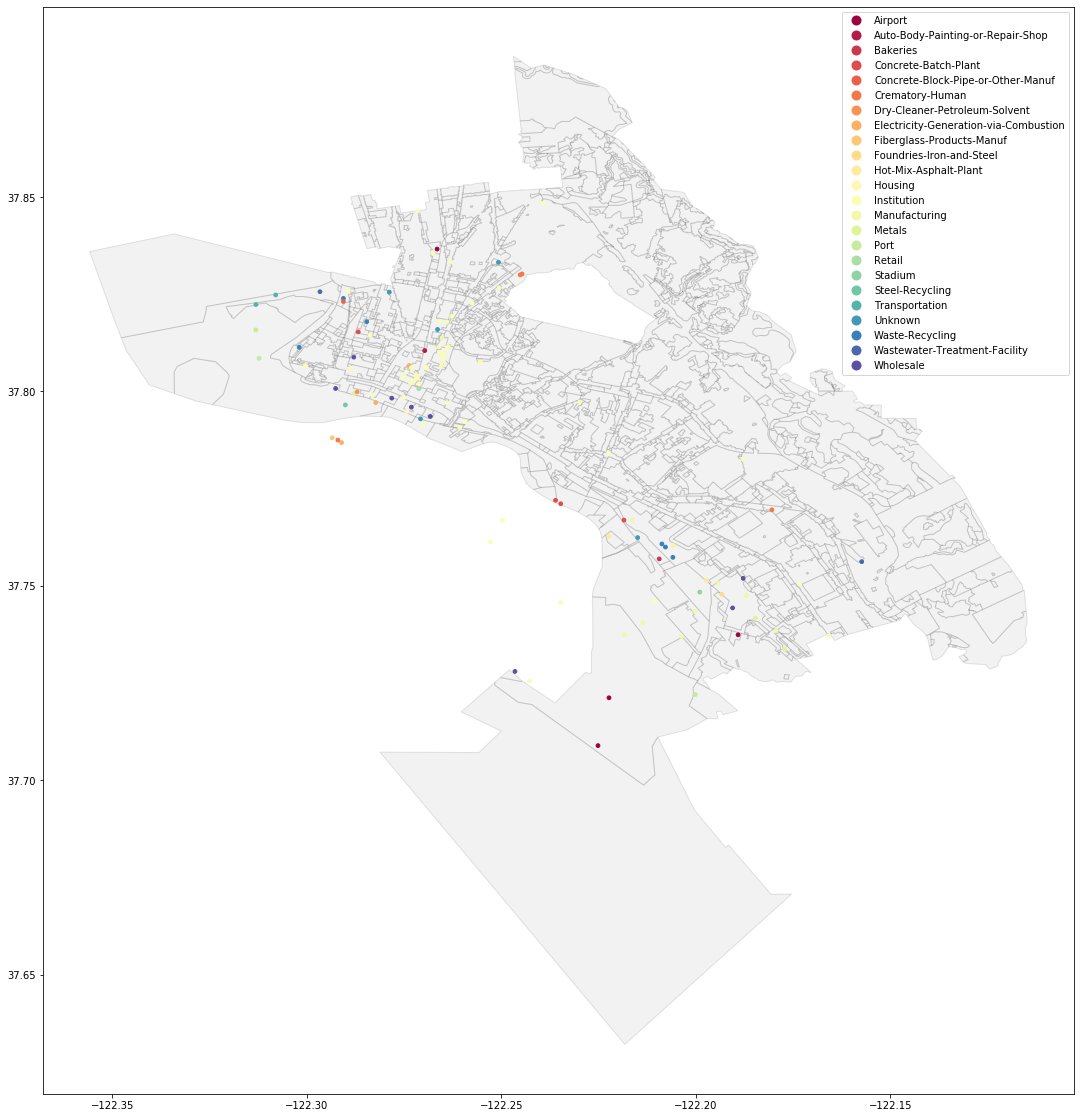

In [637]:
fig, ax = plt.subplots(figsize = (20,20)) #This creates a figure axis
oakl.plot(ax=ax, color='grey', alpha = 0.1, edgecolor='black')            # Basemap of City of Oakland from the Oakland shapefile
geo_df_facility.plot(ax=ax, cmap = 'Spectral', column = 'source-category', legend = True, markersize = 14)
#plt.legend(handles=[maroon_D, orange_D, yellow_D, darkviolet_D ,green_D, blue_D, fuchsia_D, black_D, red_D,cyan_D,
#                   peru_D, palegreen_D, pink_D, dimgrey_D, gold_D, dodgerblue_D, forestgreen_D, slateblue_D])

plt.show()

#### Create a dataframe where each column is one of the industrial facilities, with columns as latitude, longitude, PM2.5 PM10 emissions value and geometry. 

In [638]:
Oak_PM_lat = Facility_PM[['eis facility id', 'latitude']]
Oak_PM_long = Facility_PM[['eis facility id', 'longitude']]
Oak_PM_PM25 = Facility_PM[['eis facility id', 'PM25']]
Oak_PM_PM10 = Facility_PM[['eis facility id', 'PM10']]
Oak_PM_dist = Facility_PM[['eis facility id', 'dist']]
Oak_PM_geo = Facility_PM[['eis facility id', 'geometry']]


In [639]:
# Transpose all the dataframes
Oak_PM_lat = Oak_PM_lat.T
Oak_PM_long = Oak_PM_long.T
Oak_PM_PM25 = Oak_PM_PM25.T
Oak_PM_PM10 = Oak_PM_PM10.T
Oak_PM_dist = Oak_PM_dist.T
Oak_PM_geo = Oak_PM_geo.T

In [640]:
## Make the header as the first row in each transposed dataframe
Oak_PM_lat = Oak_PM_lat.rename(columns=Oak_PM_lat.iloc[0].astype(int)).drop(Oak_PM_lat.index[0])
Oak_PM_long = Oak_PM_long.rename(columns=Oak_PM_long.iloc[0].astype(int)).drop(Oak_PM_long.index[0])
Oak_PM_PM25 = Oak_PM_PM25.rename(columns=Oak_PM_PM25.iloc[0].astype(int)).drop(Oak_PM_PM25.index[0])
Oak_PM_PM10 = Oak_PM_PM10.rename(columns=Oak_PM_PM10.iloc[0].astype(int)).drop(Oak_PM_PM10.index[0])
Oak_PM_dist = Oak_PM_dist.rename(columns=Oak_PM_dist.iloc[0].astype(int)).drop(Oak_PM_dist.index[0])
Oak_PM_geo = Oak_PM_geo.rename(columns=Oak_PM_geo.iloc[0].astype(int)).drop(Oak_PM_geo.index[0])

In [641]:
## Add suffix to column header based on the dataframe type
Oak_PM_lat.columns = [str(col) + '_latitude' for col in Oak_PM_lat.columns]
Oak_PM_long.columns = [str(col) + '_longitude' for col in Oak_PM_long.columns]
Oak_PM_PM25.columns = [str(col) + '_PM25' for col in Oak_PM_PM25.columns]
Oak_PM_PM10.columns = [str(col) + '_PM10' for col in Oak_PM_PM10.columns]
Oak_PM_dist.columns = [str(col) + '_dist' for col in Oak_PM_dist.columns]
Oak_PM_geo.columns = [str(col) + '_geo' for col in Oak_PM_geo.columns]

In [642]:
## Remove index for each dataframe
Oak_PM_lat.reset_index(drop=True, inplace=True)
Oak_PM_long.reset_index(drop=True, inplace=True)
Oak_PM_PM25.reset_index(drop=True, inplace=True)
Oak_PM_PM10.reset_index(drop=True, inplace=True)
Oak_PM_dist.reset_index(drop=True, inplace=True)
Oak_PM_geo.reset_index(drop=True, inplace=True)

In [643]:
Oak_PM_combined = Oak_PM_lat.join(Oak_PM_long).join(Oak_PM_PM25).join(Oak_PM_PM10).join(Oak_PM_dist).join(Oak_PM_geo)


In [644]:
Oak_PM_combined

126911_latitude  127511_latitude  127611_latitude  127711_latitude  \
0         37.76685         37.80603         37.78422         37.83336   

   136511_latitude  137211_latitude  140211_latitude  141411_latitude  \
0         37.78683         37.82269         37.76033         37.73715   

   168411_latitude  172211_latitude  ...                   18495611_geo  \
0         37.81793         37.75042  ...  POINT (-122.272936 37.802822)   

                    18496511_geo                  18540811_geo  \
0  POINT (-122.275335 37.803681)  POINT (-122.26639 37.815923)   

                    18542011_geo                  18697111_geo  \
0  POINT (-122.271812 37.803295)  POINT (-122.27432 37.794834)   

                    18697211_geo                   18697911_geo  \
0  POINT (-122.273125 37.795936)  POINT (-122.190515 37.744311)   

                    18705211_geo                   18782611_geo  \
0  POINT (-122.208693 37.760758)  POINT (-122.207782 37.759959)   

                    18787011_geo  
0  POINT (-122.216336 37.766939)  

[1 rows x 696 columns]

In [645]:
Oak_PM_combined = Oak_PM_combined.reindex(columns=sorted(Oak_PM_combined.columns))

In [646]:
Oak_PM_combined

10452911_PM10  10452911_PM25  10452911_dist                 10452911_geo  \
0       0.051645       0.051645              0  POINT (-122.23476 37.74567)   

   10452911_latitude  10452911_longitude  10457011_PM10  10457011_PM25  \
0           37.74567          -122.23476       0.000988       0.000988   

   10457011_dist                10457011_geo  ...  7845711_dist  \
0              0  POINT (-122.17711 37.7337)  ...             0   

                   7845711_geo  7845711_latitude  7845711_longitude  \
0  POINT (-122.24515 37.82995)          37.82995         -122.24515   

   808811_PM10 808811_PM25  808811_dist                   808811_geo  \
0     0.984085    0.590966            0  POINT (-122.26824 37.79355)   

   808811_latitude  808811_longitude  
0         37.79355        -122.26824  

[1 rows x 696 columns]

In [647]:
#Create a datafram where each row contains emissions of PM10 and PM2.5 for each facility
Oak_PM_combined = Oak_PM_combined.loc[Oak_PM_combined.index.repeat(21488)].reset_index(drop=True)

In [648]:
BC_Facility = BC_df.join(Oak_PM_combined)

In [649]:
# Convert distance column to float type
for idx, col in enumerate(BC_Facility.columns):
        if "_dist" in col:
            BC_Facility[col] = pd.to_numeric(BC_Facility[col], downcast="float")


### Calculate distance between point of measurement and each facility and add it to the _dist column

In [650]:
### Defining a function to calculate the distance between two GPS coordinates (latitude and longitude)
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [651]:
BC_Facility.head()

Longitude   Latitude  BC Value       TimePeriod  \
0 -122.322594  37.806781  0.818032  Jun2015-May2016   
1 -122.322310  37.806150  0.551475  Jun2015-May2016   
2 -122.322301  37.806420  0.593712  Jun2015-May2016   
3 -122.322299  37.805880  0.489898  Jun2015-May2016   
4 -122.322267  37.806689  0.739341  Jun2015-May2016   

                      geometry  10452911_PM10  10452911_PM25  10452911_dist  \
0  POINT (-122.32259 37.80678)       0.051645       0.051645            0.0   
1  POINT (-122.32231 37.80615)       0.051645       0.051645            0.0   
2  POINT (-122.32230 37.80642)       0.051645       0.051645            0.0   
3  POINT (-122.32230 37.80588)       0.051645       0.051645            0.0   
4  POINT (-122.32227 37.80669)       0.051645       0.051645            0.0   

                  10452911_geo  10452911_latitude  ...  7845711_dist  \
0  POINT (-122.23476 37.74567)           37.74567  ...           0.0   
1  POINT (-122.23476 37.74567)           37.74567  ...           0.0   
2  POINT (-122.23476 37.74567)           37.74567  ...           0.0   
3  POINT (-122.23476 37.74567)           37.74567  ...           0.0   
4  POINT (-122.23476 37.74567)           37.74567  ...           0.0   

                   7845711_geo  7845711_latitude  7845711_longitude  \
0  POINT (-122.24515 37.82995)          37.82995         -122.24515   
1  POINT (-122.24515 37.82995)          37.82995         -122.24515   
2  POINT (-122.24515 37.82995)          37.82995         -122.24515   
3  POINT (-122.24515 37.82995)          37.82995         -122.24515   
4  POINT (-122.24515 37.82995)          37.82995         -122.24515   

  808811_PM10  808811_PM25  808811_dist                   808811_geo  \
0    0.984085     0.590966          0.0  POINT (-122.26824 37.79355)   
1    0.984085     0.590966          0.0  POINT (-122.26824 37.79355)   
2    0.984085     0.590966          0.0  POINT (-122.26824 37.79355)   
3    0.984085     0.590966          0.0  POINT (-122.26824 37.79355)   
4    0.984085     0.590966          0.0  POINT (-122.26824 37.79355)   

   808811_latitude  808811_longitude  
0         37.79355        -122.26824  
1         37.79355        -122.26824  
2         37.79355        -122.26824  
3         37.79355        -122.26824  
4         37.79355        -122.26824  

[5 rows x 701 columns]

### Calculating distance between each industrial facility and the point of measurement. 


##### The first method I tried was to iterate through all the columns, identify the columns with "_dist" as suffix, then iterate through rows to calcualte distance using the dist function. But this method took 47 seconds just for 1,000 rows. 

In [ ]:
time3 = time.time()
for idx, col in enumerate(BC_Facility.columns):
    if "_dist" in col:
        for index, row in BC_Facility.head(1000).iterrows():
            BC_Facility.at[index,col] = float(distance((row.iloc[1], row.iloc[0]), (row.iloc[idx+2], row.iloc[idx+3])))*0.621
time4 = time.time()

print(time4 - time3)

##### In the second method, I iterate through all rows, identify the rows with "_dist" as column headers, and then calculate distance using distance function

In [652]:
time1 = time.time()
for index, row in BC_Facility.iterrows():
    for idx, col in enumerate(BC_Facility.columns):
        if "_dist" in col:
            BC_Facility.at[index,col] = float(distance((row.iloc[1], row.iloc[0]), (row.iloc[idx+2], row.iloc[idx+3])))*0.621
            #BC_Facility.at[index,col] = float(row.iloc[idx])
time2 = time.time()            
    
print(time2 - time1)


94.50316309928894


In [653]:
BC_Facility.tail()

Longitude   Latitude  BC Value       TimePeriod  \
21483 -122.034943  37.560076  3.923761  Jun2015-May2016   
21484 -122.034724  37.560164  1.408693  Jun2015-May2016   
21485 -122.034681  37.559830  2.659885  Jun2015-May2016   
21486 -122.034504  37.559958  1.776353  Jun2015-May2016   
21487 -122.034503  37.559957  2.014664  Jun2015-May2016   

                          geometry  10452911_PM10  10452911_PM25  \
21483  POINT (-122.03494 37.56008)       0.051645       0.051645   
21484  POINT (-122.03472 37.56016)       0.051645       0.051645   
21485  POINT (-122.03468 37.55983)       0.051645       0.051645   
21486  POINT (-122.03450 37.55996)       0.051645       0.051645   
21487  POINT (-122.03450 37.55996)       0.051645       0.051645   

       10452911_dist                 10452911_geo  10452911_latitude  ...  \
21483      16.839720  POINT (-122.23476 37.74567)           37.74567  ...   
21484      16.842861  POINT (-122.23476 37.74567)           37.74567  ...   
21485      16.861923  POINT (-122.23476 37.74567)           37.74567  ...   
21486      16.861498  POINT (-122.23476 37.74567)           37.74567  ...   
21487      16.861532  POINT (-122.23476 37.74567)           37.74567  ...   

       7845711_dist                  7845711_geo  7845711_latitude  \
21483     21.890516  POINT (-122.24515 37.82995)          37.82995   
21484     21.891621  POINT (-122.24515 37.82995)          37.82995   
21485     21.912464  POINT (-122.24515 37.82995)          37.82995   
21486     21.910042  POINT (-122.24515 37.82995)          37.82995   
21487     21.910076  POINT (-122.24515 37.82995)          37.82995   

       7845711_longitude 808811_PM10  808811_PM25  808811_dist  \
21483         -122.24515    0.984085     0.590966    20.554436   
21484         -122.24515    0.984085     0.590966    20.557091   
21485         -122.24515    0.984085     0.590966    20.576624   
21486         -122.24515    0.984085     0.590966    20.575716   
21487         -122.24515    0.984085     0.590966    20.575750   

                        808811_geo  808811_latitude  808811_longitude  
21483  POINT (-122.26824 37.79355)         37.79355        -122.26824  
21484  POINT (-122.26824 37.79355)         37.79355        -122.26824  
21485  POINT (-122.26824 37.79355)         37.79355        -122.26824  
21486  POINT (-122.26824 37.79355)         37.79355        -122.26824  
21487  POINT (-122.26824 37.79355)         37.79355        -122.26824  

[5 rows x 701 columns]

### Write this to a dataframe
BC_Facility.to_csv("Data/BC_Facility.csv")

##### Drop latitude, longitude and emissions since we don't need those columns. Latitude and longitude values are captured in the distance column. Since all the emissions values are the same, that feature would not be important

In [655]:
BC_Facility = BC_Facility.loc[:,~BC_Facility.columns.str.contains('_PM10', case=False)] 
BC_Facility = BC_Facility.loc[:,~BC_Facility.columns.str.contains('_PM25', case=False)] 
BC_Facility = BC_Facility.loc[:,~BC_Facility.columns.str.contains('_latitude', case=False)]
BC_Facility = BC_Facility.loc[:,~BC_Facility.columns.str.contains('_longitude', case=False)] 

In [656]:
BC_Facility.head()

Longitude   Latitude  BC Value       TimePeriod  \
0 -122.322594  37.806781  0.818032  Jun2015-May2016   
1 -122.322310  37.806150  0.551475  Jun2015-May2016   
2 -122.322301  37.806420  0.593712  Jun2015-May2016   
3 -122.322299  37.805880  0.489898  Jun2015-May2016   
4 -122.322267  37.806689  0.739341  Jun2015-May2016   

                      geometry  10452911_dist                 10452911_geo  \
0  POINT (-122.32259 37.80678)       6.386582  POINT (-122.23476 37.74567)   
1  POINT (-122.32231 37.80615)       6.346233  POINT (-122.23476 37.74567)   
2  POINT (-122.32230 37.80642)       6.358146  POINT (-122.23476 37.74567)   
3  POINT (-122.32230 37.80588)       6.333521  POINT (-122.23476 37.74567)   
4  POINT (-122.32227 37.80669)       6.369023  POINT (-122.23476 37.74567)   

   10457011_dist                10457011_geo  10457511_dist  ... 771711_dist  \
0       9.408835  POINT (-122.17711 37.7337)       1.995507  ...    7.073346   
1       9.372474  POINT (-122.17711 37.7337)       1.970443  ...    7.038703   
2       9.382011  POINT (-122.17711 37.7337)       1.974141  ...    7.047287   
3       9.362026  POINT (-122.17711 37.7337)       1.965829  ...    7.029188   
4       9.390396  POINT (-122.17711 37.7337)       1.976688  ...    7.054695   

                      771711_geo 772011_dist                  772011_geo  \
0  POINT (-122.209381 37.756914)    2.298349  POINT (-122.28229 37.7971)   
1  POINT (-122.209381 37.756914)    2.271180  POINT (-122.28229 37.7971)   
2  POINT (-122.209381 37.756914)    2.275900  POINT (-122.28229 37.7971)   
3  POINT (-122.209381 37.756914)    2.265535  POINT (-122.28229 37.7971)   
4  POINT (-122.209381 37.756914)    2.279456  POINT (-122.28229 37.7971)   

  773811_dist                   773811_geo 7845711_dist  \
0    7.441341  POINT (-122.21835 37.73733)     4.517235   
1    7.401484  POINT (-122.21835 37.73733)     4.518436   
2    7.413087  POINT (-122.21835 37.73733)     4.511207   
3    7.389061  POINT (-122.21835 37.73733)     4.524693   
4    7.423634  POINT (-122.21835 37.73733)     4.502830   

                   7845711_geo 808811_dist                   808811_geo  
0  POINT (-122.24515 37.82995)    3.103170  POINT (-122.26824 37.79355)  
1  POINT (-122.24515 37.82995)    3.075784  POINT (-122.26824 37.79355)  
2  POINT (-122.24515 37.82995)    3.080629  POINT (-122.26824 37.79355)  
3  POINT (-122.24515 37.82995)    3.069979  POINT (-122.26824 37.79355)  
4  POINT (-122.24515 37.82995)    3.084273  POINT (-122.26824 37.79355)  

[5 rows x 237 columns]

#### Write the trimmed dataframe to a csv file
BC_Facility.to_csv("Data/BC_Facility_Trimmed.csv")

In [658]:
BC_Facility = pd.read_csv("Data/BC_Facility_Trimmed.csv")

### Combining Air Pollution Monitoring Data, Facility level data and traffic data

#### Create a dataframe where each column is one of the traffic intersections, with columns as latitude, longitude, AADT and geometry. 

In [702]:
traffic.head()

Description    AADT   Latitude   Longitude
0        ALAMEDA, BROADWAY/ ENCINAL AVENUE    8700  37.760576 -122.240708
1  ALAMEDA, CENTRAL AVENUE/ SHERMAN STREET    9500  37.770910 -122.263477
3                   OAKLAND, JCT. RTE. 880   22900  37.769397 -122.221166
4                OAKLAND, EAST 12TH STREET   16400  37.772068 -122.217378
6        SAN FRANCISCO/ALAMEDA COUNTY LINE  278000  37.818854 -122.349603

In [703]:
## Assign an intersection number to each traffic intersection instead of using description
traffic.reset_index(inplace=True)

In [704]:
#Rename index as Intersection
traffic.rename(columns={"index":"Intersection"}, inplace=True)

In [705]:
#Drop the description column
traffic.drop(columns=['Description'], inplace=True)

In [706]:
### Add an empty column for distance
traffic['dist'] = 0
traffic['dist'].astype(float)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
66    0.0
67    0.0
68    0.0
69    0.0
70    0.0
Name: dist, Length: 71, dtype: float64

In [707]:
traffic_lat = traffic[['Intersection', 'Latitude']].T
traffic_long = traffic[['Intersection', 'Longitude']].T
traffic_AADT = traffic[['Intersection', 'AADT']].T
traffic_dist = traffic[['Intersection', 'dist']].T
traffic_geo = traffic[['Intersection', 'geometry']].T


KeyError: "['geometry'] not in index"

In [665]:
traffic_lat.head()

0         1          2          3          4          5   \
Intersection   0.000000   1.00000   3.000000   4.000000   6.000000   7.000000   
Latitude      37.760576  37.77091  37.769397  37.772068  37.818854  37.823843   

                     6        7          8          9   ...         61  \
Intersection   8.000000   9.0000  10.000000  11.000000  ...  79.000000   
Latitude      37.824855  37.8252  37.826401  37.837849  ...  37.796197   

                     62         63         64         65         66  \
Intersection  80.000000  81.000000  82.000000  83.000000  84.000000   
Latitude      37.799155  37.802161  37.804525  37.813292  37.815518   

                     67         68        69        70  
Intersection  85.000000  91.000000  92.00000  93.00000  
Latitude      37.821345  37.799143  37.80688  37.80949  

[2 rows x 71 columns]

In [666]:
## Make the header as the first row in each transposed dataframe
traffic_lat = traffic_lat.rename(columns=traffic_lat.iloc[0].astype(int)).drop(traffic_lat.index[0])
traffic_long = traffic_long.rename(columns=traffic_long.iloc[0].astype(int)).drop(traffic_long.index[0])
traffic_AADT = traffic_AADT.rename(columns=traffic_AADT.iloc[0].astype(int)).drop(traffic_AADT.index[0])
traffic_dist = traffic_dist.rename(columns=traffic_dist.iloc[0].astype(int)).drop(traffic_dist.index[0])
traffic_geo = traffic_geo.rename(columns=traffic_geo.iloc[0].astype(int)).drop(traffic_geo.index[0])

In [667]:
## Add suffix to column header based on the dataframe type
traffic_lat.columns = [str(col) + '_latitude' for col in traffic_lat.columns]
traffic_long.columns = [str(col) + '_longitude' for col in traffic_long.columns]
traffic_AADT.columns = [str(col) + '_AADT' for col in traffic_AADT.columns]
traffic_dist.columns = [str(col) + '_traf_dist' for col in traffic_dist.columns]
traffic_geo.columns = [str(col) + '_geo' for col in traffic_geo.columns]

In [668]:
## Remove index for each dataframe
traffic_lat.reset_index(drop=True, inplace=True)
traffic_long.reset_index(drop=True, inplace=True)
traffic_AADT.reset_index(drop=True, inplace=True)
traffic_dist.reset_index(drop=True, inplace=True)
traffic_geo.reset_index(drop=True, inplace=True)

In [669]:
traffic_combined = traffic_lat.join(traffic_long).join(traffic_AADT).join(traffic_dist).join(traffic_geo)


In [670]:
traffic_combined

0_latitude  1_latitude  3_latitude  4_latitude  6_latitude  7_latitude  \
0   37.760576    37.77091   37.769397   37.772068   37.818854   37.823843   

   8_latitude  9_latitude  10_latitude  11_latitude  ...  \
0   37.824855     37.8252    37.826401    37.837849  ...   

                                 79_geo                                80_geo  \
0  POINT (-122.268861055 37.7961974865)  POINT (-122.276314697 37.7991552558)   

                                 81_geo                               82_geo  \
0  POINT (-122.295484996 37.8021614459)  POINT (-122.30272491 37.8045252655)   

                                 83_geo                                84_geo  \
0  POINT (-122.302016965 37.8132921671)  POINT (-122.298635478 37.8155178024)   

                                85_geo                               91_geo  \
0  POINT (-122.292823965 37.821344812)  POINT (-122.276152929 37.799143267)   

                            92_geo                           93_geo  
0  POINT (-122.277795333 37.80688)  POINT (-122.276034999 37.80949)  

[1 rows x 355 columns]

In [671]:
traffic_combined = traffic_combined.reindex(columns=sorted(traffic_combined.columns))

In [672]:
#Create a datafram where each row contains emissions of PM10 and PM2.5 for each facility
traffic_combined = traffic_combined.loc[traffic_combined.index.repeat(21488)].reset_index(drop=True)

In [673]:
BC_Facility_Traffic = BC_Facility.join(traffic_combined)

In [674]:
BC_Facility_Traffic.drop(BC_Facility_Traffic.columns[[0, 1]], axis=1, inplace=True)

In [675]:
BC_Facility_Traffic.head()

Latitude  BC Value       TimePeriod  \
0  37.806781  0.818032  Jun2015-May2016   
1  37.806150  0.551475  Jun2015-May2016   
2  37.806420  0.593712  Jun2015-May2016   
3  37.805880  0.489898  Jun2015-May2016   
4  37.806689  0.739341  Jun2015-May2016   

                                 geometry  10452911_dist  \
0        POINT (-122.3225938 37.80678062)       6.386582   
1          POINT (-122.32231 37.80614989)       6.346233   
2        POINT (-122.3223008 37.80642014)       6.358146   
3  POINT (-122.3222988 37.80587979999999)       6.333521   
4        POINT (-122.3222671 37.80668898)       6.369023   

                  10452911_geo  10457011_dist                10457011_geo  \
0  POINT (-122.23476 37.74567)       9.408835  POINT (-122.17711 37.7337)   
1  POINT (-122.23476 37.74567)       9.372474  POINT (-122.17711 37.7337)   
2  POINT (-122.23476 37.74567)       9.382011  POINT (-122.17711 37.7337)   
3  POINT (-122.23476 37.74567)       9.362026  POINT (-122.17711 37.7337)   
4  POINT (-122.23476 37.74567)       9.390396  POINT (-122.17711 37.7337)   

   10457511_dist                 10457511_geo  ...  93_AADT  \
0       1.995507  POINT (-122.28708 37.79987)  ...   140700   
1       1.970443  POINT (-122.28708 37.79987)  ...   140700   
2       1.974141  POINT (-122.28708 37.79987)  ...   140700   
3       1.965829  POINT (-122.28708 37.79987)  ...   140700   
4       1.976688  POINT (-122.28708 37.79987)  ...   140700   

                            93_geo  93_latitude 93_longitude  93_traf_dist  \
0  POINT (-122.276034999 37.80949)     37.80949  -122.276035             0   
1  POINT (-122.276034999 37.80949)     37.80949  -122.276035             0   
2  POINT (-122.276034999 37.80949)     37.80949  -122.276035             0   
3  POINT (-122.276034999 37.80949)     37.80949  -122.276035             0   
4  POINT (-122.276034999 37.80949)     37.80949  -122.276035             0   

   9_AADT                                9_geo 9_latitude  9_longitude  \
0  157500  POINT (-122.304611578 37.825200142)    37.8252  -122.304612   
1  157500  POINT (-122.304611578 37.825200142)    37.8252  -122.304612   
2  157500  POINT (-122.304611578 37.825200142)    37.8252  -122.304612   
3  157500  POINT (-122.304611578 37.825200142)    37.8252  -122.304612   
4  157500  POINT (-122.304611578 37.825200142)    37.8252  -122.304612   

  9_traf_dist  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 591 columns]

In [676]:
# Convert distance column to float type
for idx, col in enumerate(BC_Facility_Traffic.columns):
        if "_traf_dist" in col:
            BC_Facility_Traffic[col] = pd.to_numeric(BC_Facility_Traffic[col], downcast="float")


#### Calculate distance between each traffic intersection and point of measurement and store this in the _dist column

In [677]:
for index, row in BC_Facility_Traffic.iterrows():
    for idx, col in enumerate(BC_Facility_Traffic.columns):
        if "_traf_dist" in col:            
            BC_Facility_Traffic.at[index,col] = float(distance((row.iloc[1], row.iloc[0]), (row.iloc[idx-2], row.iloc[idx-1])))
            #BC_Facility_Traffic.at[index,col] = float(row.iloc[idx])



In [678]:
BC_Facility_Traffic

Latitude  BC Value       TimePeriod  \
0      37.806781  0.818032  Jun2015-May2016   
1      37.806150  0.551475  Jun2015-May2016   
2      37.806420  0.593712  Jun2015-May2016   
3      37.805880  0.489898  Jun2015-May2016   
4      37.806689  0.739341  Jun2015-May2016   
...          ...       ...              ...   
21483  37.560076  3.923761  Jun2015-May2016   
21484  37.560164  1.408693  Jun2015-May2016   
21485  37.559830  2.659885  Jun2015-May2016   
21486  37.559958  1.776353  Jun2015-May2016   
21487  37.559957  2.014664  Jun2015-May2016   

                                     geometry  10452911_dist  \
0            POINT (-122.3225938 37.80678062)       6.386582   
1              POINT (-122.32231 37.80614989)       6.346233   
2            POINT (-122.3223008 37.80642014)       6.358146   
3      POINT (-122.3222988 37.80587979999999)       6.333521   
4            POINT (-122.3222671 37.80668898)       6.369023   
...                                       ...            ...   
21483         POINT (-122.034943 37.56007563)      16.839720   
21484         POINT (-122.0347241 37.5601636)      16.842861   
21485        POINT (-122.0346807 37.55983036)      16.861923   
21486        POINT (-122.0345038 37.55995784)      16.861498   
21487        POINT (-122.0345034 37.55995746)      16.861532   

                      10452911_geo  10457011_dist                10457011_geo  \
0      POINT (-122.23476 37.74567)       9.408835  POINT (-122.17711 37.7337)   
1      POINT (-122.23476 37.74567)       9.372474  POINT (-122.17711 37.7337)   
2      POINT (-122.23476 37.74567)       9.382011  POINT (-122.17711 37.7337)   
3      POINT (-122.23476 37.74567)       9.362026  POINT (-122.17711 37.7337)   
4      POINT (-122.23476 37.74567)       9.390396  POINT (-122.17711 37.7337)   
...                            ...            ...                         ...   
21483  POINT (-122.23476 37.74567)      14.288367  POINT (-122.17711 37.7337)   
21484  POINT (-122.23476 37.74567)      14.289785  POINT (-122.17711 37.7337)   
21485  POINT (-122.23476 37.74567)      14.310388  POINT (-122.17711 37.7337)   
21486  POINT (-122.23476 37.74567)      14.308268  POINT (-122.17711 37.7337)   
21487  POINT (-122.23476 37.74567)      14.308302  POINT (-122.17711 37.7337)   

       10457511_dist                 10457511_geo  ...  93_AADT  \
0           1.995507  POINT (-122.28708 37.79987)  ...   140700   
1           1.970443  POINT (-122.28708 37.79987)  ...   140700   
2           1.974141  POINT (-122.28708 37.79987)  ...   140700   
3           1.965829  POINT (-122.28708 37.79987)  ...   140700   
4           1.976688  POINT (-122.28708 37.79987)  ...   140700   
...              ...                          ...  ...      ...   
21483      21.541761  POINT (-122.28708 37.79987)  ...   140700   
21484      21.544743  POINT (-122.28708 37.79987)  ...   140700   
21485      21.563963  POINT (-122.28708 37.79987)  ...   140700   
21486      21.563377  POINT (-122.28708 37.79987)  ...   140700   
21487      21.563412  POINT (-122.28708 37.79987)  ...   140700   

                                93_geo  93_latitude 93_longitude  \
0      POINT (-122.276034999 37.80949)     37.80949  -122.276035   
1      POINT (-122.276034999 37.80949)     37.80949  -122.276035   
2      POINT (-122.276034999 37.80949)     37.80949  -122.276035   
3      POINT (-122.276034999 37.80949)     37.80949  -122.276035   
4      POINT (-122.276034999 37.80949)     37.80949  -122.276035   
...                                ...          ...          ...   
21483  POINT (-122.276034999 37.80949)     37.80949  -122.276035   
21484  POINT (-122.276034999 37.80949)     37.80949  -122.276035   
21485  POINT (-122.276034999 37.80949)     37.80949  -122.276035   
21486  POINT (-122.276034999 37.80949)     37.80949  -122.276035   
21487  POINT (-122.276034999 37.80949)     37.80949  -122.276035   

       93_traf_dist  9_AADT                                9_geo 9_latitude  \


#### Write this to a dataframe
BC_Facility_Traffic.to_csv("Data/BC_Facility_Traffic.csv")

#### Similar to the facility dataframe, drop latitude and longitude since its captured in the distance column. Also drop AADT

In [680]:
BC_Facility_Traffic.drop(list(BC_Facility_Traffic.filter(regex = '_latitude')), axis = 1, inplace = True)

In [681]:
BC_Facility_Traffic.drop(list(BC_Facility_Traffic.filter(regex = '_longitude')), axis = 1, inplace = True)

In [682]:
BC_Facility_Traffic.drop(list(BC_Facility_Traffic.filter(regex = '_AADT')), axis = 1, inplace = True)

In [683]:
BC_Facility_Traffic.head()

Latitude  BC Value       TimePeriod  \
0  37.806781  0.818032  Jun2015-May2016   
1  37.806150  0.551475  Jun2015-May2016   
2  37.806420  0.593712  Jun2015-May2016   
3  37.805880  0.489898  Jun2015-May2016   
4  37.806689  0.739341  Jun2015-May2016   

                                 geometry  10452911_dist  \
0        POINT (-122.3225938 37.80678062)       6.386582   
1          POINT (-122.32231 37.80614989)       6.346233   
2        POINT (-122.3223008 37.80642014)       6.358146   
3  POINT (-122.3222988 37.80587979999999)       6.333521   
4        POINT (-122.3222671 37.80668898)       6.369023   

                  10452911_geo  10457011_dist                10457011_geo  \
0  POINT (-122.23476 37.74567)       9.408835  POINT (-122.17711 37.7337)   
1  POINT (-122.23476 37.74567)       9.372474  POINT (-122.17711 37.7337)   
2  POINT (-122.23476 37.74567)       9.382011  POINT (-122.17711 37.7337)   
3  POINT (-122.23476 37.74567)       9.362026  POINT (-122.17711 37.7337)   
4  POINT (-122.23476 37.74567)       9.390396  POINT (-122.17711 37.7337)   

   10457511_dist                 10457511_geo  ...  \
0       1.995507  POINT (-122.28708 37.79987)  ...   
1       1.970443  POINT (-122.28708 37.79987)  ...   
2       1.974141  POINT (-122.28708 37.79987)  ...   
3       1.965829  POINT (-122.28708 37.79987)  ...   
4       1.976688  POINT (-122.28708 37.79987)  ...   

                                  8_geo   8_traf_dist  \
0  POINT (-122.306416622 37.8248552647)  15258.047852   
1  POINT (-122.306416622 37.8248552647)  15285.230469   
2  POINT (-122.306416622 37.8248552647)  15280.932617   
3  POINT (-122.306416622 37.8248552647)  15291.500977   
4  POINT (-122.306416622 37.8248552647)  15266.079102   

                                91_geo  91_traf_dist  \
0  POINT (-122.276152929 37.799143267)  15259.189453   
1  POINT (-122.276152929 37.799143267)  15286.361328   
2  POINT (-122.276152929 37.799143267)  15282.065430   
3  POINT (-122.276152929 37.799143267)  15292.629883   
4  POINT (-122.276152929 37.799143267)  15267.217773   

                            92_geo  92_traf_dist  \
0  POINT (-122.277795333 37.80688)  15258.517578   
1  POINT (-122.277795333 37.80688)  15285.691406   
2  POINT (-122.277795333 37.80688)  15281.394531   
3  POINT (-122.277795333 37.80688)  15291.959961   
4  POINT (-122.277795333 37.80688)  15266.545898   

                            93_geo  93_traf_dist  \
0  POINT (-122.276034999 37.80949)  15258.189453   
1  POINT (-122.276034999 37.80949)  15285.362305   
2  POINT (-122.276034999 37.80949)  15281.066406   
3  POINT (-122.276034999 37.80949)  15291.630859   
4  POINT (-122.276034999 37.80949)  15266.217773   

                                 9_geo   9_traf_dist  
0  POINT (-122.304611578 37.825200142)  15257.935547  
1  POINT (-122.304611578 37.825200142)  15285.117188  
2  POINT (-122.304611578 37.825200142)  15280.819336  
3  POINT (-122.304611578 37.825200142)  15291.387695  
4  POINT (-122.304611578 37.825200142)  15265.966797  

[5 rows x 378 columns]

In [684]:
# Write to a dataframe
BC_Facility_Traffic.to_csv("Data/BC_Facility_Traffic_Trimmed.csv")

### Mapping weather data with traffic and facilities

In [685]:
met = pd.read_csv("Data/daymet_avg_15_16.csv")

In [686]:
met.drop(columns = ['Unnamed: 0'], inplace=True)

In [687]:
met.head()

Daylen    Precip   Radiation    Maxtemp    Mintemp    Pressure  \
0  43223.606557  1.650273  341.831694  20.744536  11.528689  922.076503   
1  43223.606557  1.573770  344.874317  21.258197  11.527322  919.453552   
2  43223.606557  1.650273  341.831694  20.744536  11.528689  922.076503   
3  43223.606557  1.573770  344.874317  21.258197  11.527322  919.453552   
4  43223.606557  1.650273  341.831694  20.744536  11.528689  922.076503   

    Latitude   Longitude  
0  37.806781 -122.322594  
1  37.806781 -122.322594  
2  37.806150 -122.322310  
3  37.806150 -122.322310  
4  37.806420 -122.322301

In [690]:
BC_Facility_Traffic_Met  = pd.merge(left=BC_Facility_Traffic, right=met, left_on=['Latitude','Longitude'], right_on=['Latitude','Longitude'])

KeyError: 'Longitude'

In [ ]:
corr = BC_Facility_Traffic.corr()

In [ ]:
fig, ax = plt.subplots(figsize=(30, 20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=500),
    square=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()